In [11]:
import hashlib
from pathlib import Path
import joblib
from tqdm.auto import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import AgglomerativeClustering

## Data dependencies

```
data/emit_df_all.pkl 3aa1fb
```

In [2]:
paths = ["data/emit_df_all.pkl"]
h = hashlib.sha1()
h.update(Path(paths[0]).read_bytes())
print(paths[0], h.hexdigest()[:6])

data/emit_df_all.pkl 3aa1fb


In [3]:
emit_data = pd.read_pickle("data/emit_df_all.pkl")

In [12]:
emit_data.shape

(29218, 6)

In [6]:
emit_data.phone.unique()

array(['<blk>', 'm', 'k', 'j', 'i', 'ə', 'n', 't̪ʰ', 'u', 'l̪', 'w', 'a',
       't̪', 'e', 's̪', 'o', 'ŋ', 'x', 'p', 't', 'ɤ', 'ʂ', 'ɕ', 'y', 'l',
       's', 'ɹ', 'ɰ', 'f', 'kʰ', 'pʰ', 'tʰ', 'ʐ', 'ɥ', 'ʃ'], dtype=object)

## Clustering

In [4]:
centroids_df = emit_data.loc[emit_data.phone!="<blk>",:].groupby("phone").agg({'bilstm': 'mean'})
centroids = np.vstack(centroids_df.bilstm.to_numpy())
phones = centroids_df.index.values

In [5]:
model = AgglomerativeClustering(n_clusters=None, distance_threshold=0)
model = model.fit(centroids)

In [6]:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html
def build_linkage_matrix(model):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    Z = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram    
    return Z

## Visualize clusters

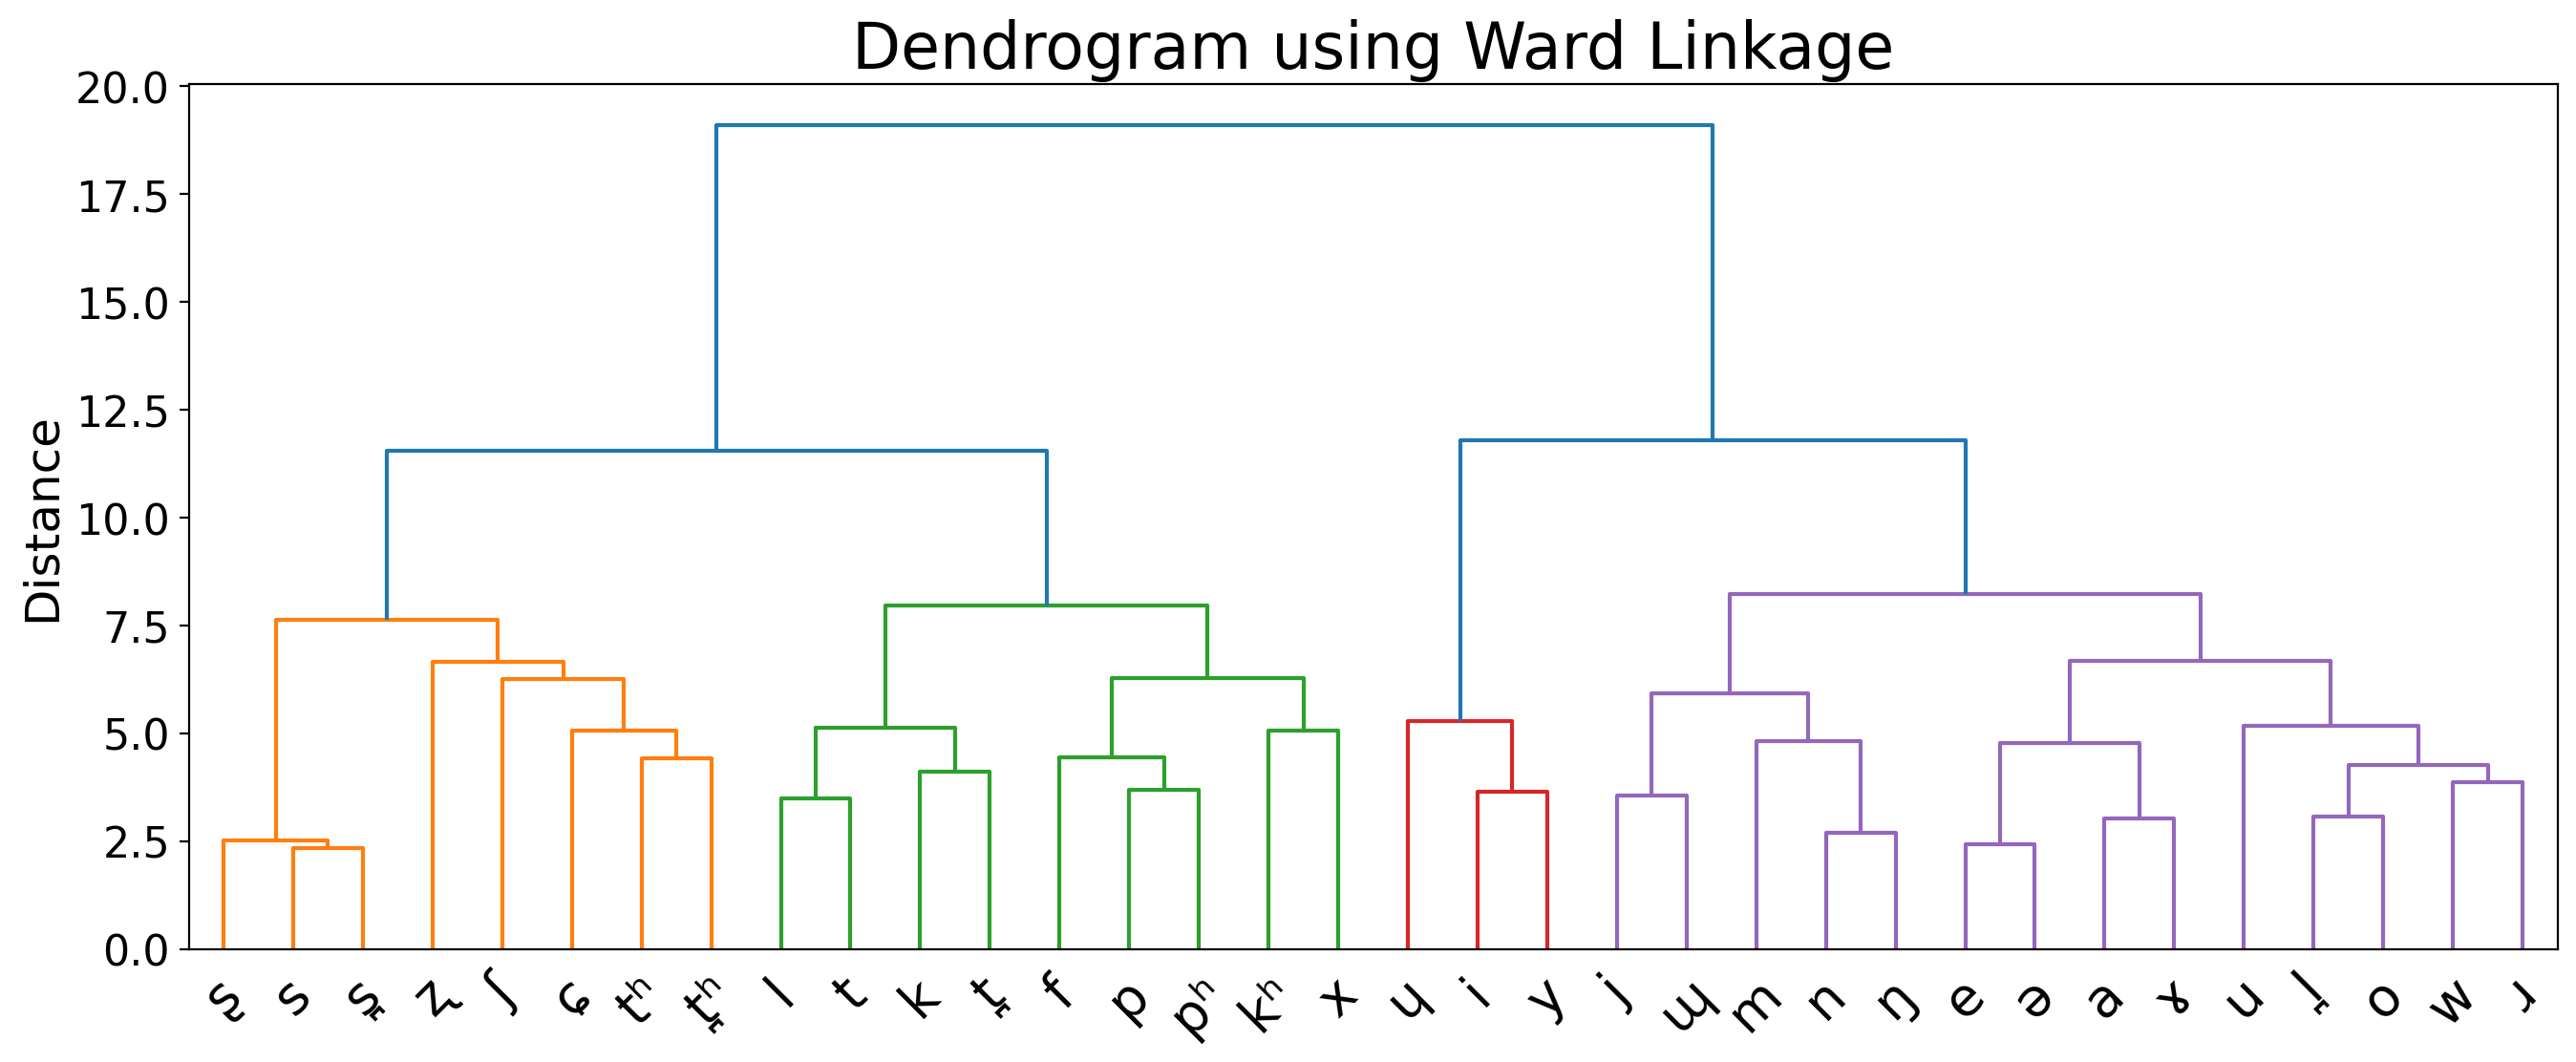

In [7]:
from scipy.cluster.hierarchy import dendrogram
fig_ward = plt.figure(figsize=(16,6), dpi=200)
Z = build_linkage_matrix(model)
dendro_obj = dendrogram(Z, color_threshold=0.5*max(Z[:,2]), 
                        labels=phones)
plt.gca().tick_params(axis='x', labelsize=20)
plt.gca().tick_params(axis='y', labelsize=16)
plt.title("Dendrogram using Ward Linkage", fontsize=24)
plt.ylabel("Distance", fontsize=18)
fig_ward.savefig("phone_dendro.png")

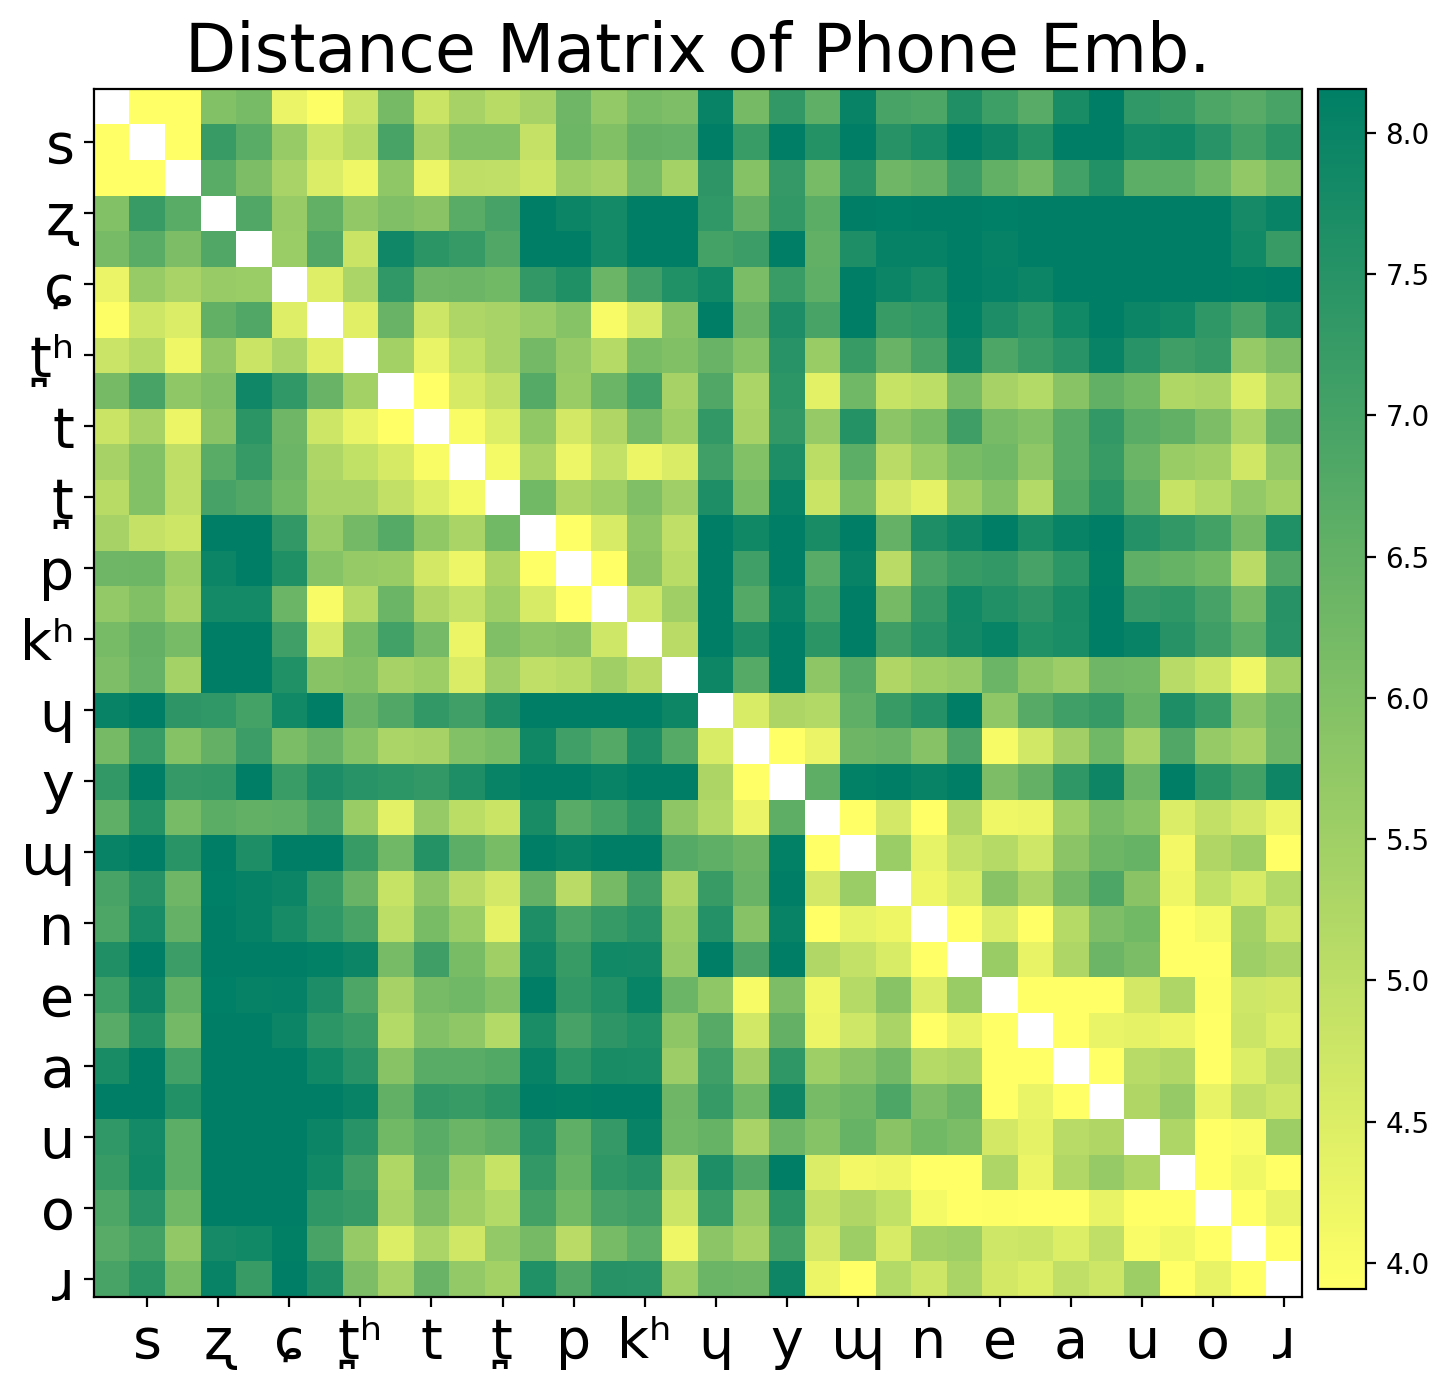

In [8]:
fig_D = plt.figure(figsize=(8,8), dpi=200)
D = squareform(pdist(centroids))
phone_order = dendro_obj["leaves"]
phones_sorted = phones[phone_order]
pD = D[phone_order, :][:, phone_order]
ql, qh = np.nanquantile(pD[np.tril_indices(pD.shape[0])], [0.1,0.9])
pD[pD < ql] = ql
pD[pD > qh] = qh
np.fill_diagonal(pD, np.NaN)
ax = plt.imshow(pD, cmap="summer_r")
_ = plt.xticks(np.arange(1,len(phones_sorted), 2), phones_sorted[1::2], fontsize=20)
_ = plt.yticks(np.arange(1,len(phones_sorted), 2), phones_sorted[1::2], fontsize=20)
plt.gca().set_title("Distance Matrix of Phone Emb.", fontsize=24)
cax = plt.axes([0.90, 0.13, 0.03, 0.75])
plt.colorbar(cax=cax)
fig_D.savefig("phone_matrix.png")

## Output Hashes

```
phone_dendro.png	95b11b
phone_matrix.png	77af32
```

In [9]:
out_paths = ["phone_dendro.png", "phone_matrix.png"]
for path_x in out_paths:
    h = hashlib.sha1()
    h.update(Path(path_x).read_bytes())
    print(path_x, h.hexdigest()[:6], sep="\t")

phone_dendro.png	95b11b
phone_matrix.png	77af32
